# Kickstarter Project New Model

In thise notebook we need to take some information from our first notebook "kickstarter EDA" for the Setup & Data Preparation. After that we will start with a second try and create our new models. In this case **AdaBoost**. 

So you can skip the first part as it's just some repition from our EDA notebook. Jump right into the models [here](#model).

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sms
import copy
import glob

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.display import Image
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
#tabelle = pd.read_excel('List_features_EDA.xlsx', sheet_name = 'Jupyter', na_values = ['.','*'])

In [3]:
# get data 
path =r'/Users/raphaelaboll/nf-sep-20/Project_2/data'
filenames = glob.glob(path + "/*.csv")
dfs = []
for filename in filenames:
       dfs.append(pd.read_csv(filename))
# Concatenate all data into one DataFrame
df = pd.concat(dfs, ignore_index=True)

# Data Cleaning

## Check for nullvalues
As we can see the following features *friends, is_backing, is_starred and permissions* can be dropped due to missing data issue.

In [4]:
# checking null values
nan = pd.DataFrame(df.isnull().sum(),columns=['Count'])
nan['Percentage'] = round(nan.Count/df.shape[0]*100,1)
print(nan[nan.Count!=0])

              Count  Percentage
blurb             8         0.0
friends      208922        99.9
is_backing   208922        99.9
is_starred   208922        99.9
location        226         0.1
permissions  208922        99.9
usd_type        480         0.2


## Check for duplicates
No relevant duplicate.

In [5]:
# generate count statistics of duplicate entries
if len(df[df.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(df[df.duplicated()]))
    print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
else:
    print("No duplicated entries found")

No duplicated entries found


## Check and change of the datatypes

### Datetime Issues
We changed the features *deadline* and *launched_at* and created a new feature *duration*. The dates created_at and state_changed_at will be dropped.

In [6]:
# change Date-times deadline
df['deadline'] = pd.to_datetime(df['deadline'], unit='s')

In [7]:
# split date to year and month and delete deadline later 
df['year_deadline'] = df['deadline'].dt.year 
df['month_deadline'] = df['deadline'].dt.month 
df['day_deadline'] = df['deadline'].dt.day
df['time_deadline'] = df['deadline'].dt.time

In [8]:
# change Date-times launched_at
df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s')

In [9]:
# split date to year and month and delete deadline later 
df['year_launched'] = df['launched_at'].dt.year 
df['month_launched'] = df['launched_at'].dt.month 
df['day_launched'] = df['launched_at'].dt.day
df['time_launched'] = df['launched_at'].dt.time

In [10]:
# Launch day of week
df['day_launched'] = df['launched_at'].dt.weekday_name
df.day_launched.value_counts()

Tuesday      43340
Monday       36958
Wednesday    36593
Thursday     31953
Friday       31051
Saturday     16184
Sunday       13143
Name: day_launched, dtype: int64

##  Datachange due to inconsistency reasons

### goal_USD


In [11]:
# The information in feature goal has different currencies. This needs to be changed
df["goal_usd"]=df["goal"]*df["static_usd_rate"]

### state (target variable)
We only consider the states which can be used for predictions.

In [12]:
# We only consider the states which can be used for prediction
df.query("state in ['failed','successful']", inplace=True)

## Check for outliners
Outliners can only occur for the following features: usd_pledged, goal_usd and backers_count.

In [13]:
# check for outliners
outliners = pd.DataFrame(round(df[['usd_pledged','goal_usd','backers_count']].describe(percentiles=[0.25, 0.5, 
                                                                                                    0.75, 0.9, 0.95,0.99]),1))
outliners

,usd_pledged,goal_usd,backers_count
count,192664.0,192664.0,192664.0
mean,13516.7,37787.7,152.6
std,89184.0,1065708.8,898.3
min,0.0,0.0,0.0
25%,150.0,1500.0,4.0
50%,1772.0,5000.0,30.0
75%,7096.6,12447.0,94.2
90%,21459.6,33612.6,255.0
95%,42758.6,60000.0,506.0
99%,189111.4,250000.0,2072.4


In [14]:
df_outliners_99=df.query("usd_pledged<189111.4	and goal_usd<250000.0 and backers_count<2072.4")
df_outliners_99.shape[0]/ df.shape[0]

0.9757868621018976

In [15]:
df=df_outliners_99

## Datasplit

We will split the feature *category* to a new feature *Sub- and Maincategory*.

In [16]:
# split column category
import ast
df_cat = (pd.DataFrame(df['category'].apply(ast.literal_eval).values.tolist()))

In [17]:
# New Column subcategory_name
df["subcategory_name"]=df_cat.name
df.subcategory_name.head()

1               Rock
2      Playing Cards
3         Nonfiction
4    Classical Music
5    Classical Music
Name: subcategory_name, dtype: object

In [18]:
# new column maincategory
df["maincategory"]=df_cat.parent_id
df.maincategory.fillna(0,inplace=True)
df.maincategory.astype(int)

1         14
2         12
3         18
4         14
5         14
6          0
7         17
8          9
9         10
10        18
11        14
13        18
14        17
15        15
16        10
17        17
18        18
19         9
20        14
21        18
22         1
23         0
24         9
25        10
26        14
28        16
29         0
30        12
31        18
32         1
          ..
209192     0
209193     0
209194     0
209195     0
209196     0
209197     0
209198     0
209199     0
209200     0
209201     0
209202     0
209203     0
209204     0
209205     0
209206     0
209207     0
209208     0
209209     0
209210     0
209211     0
209212     0
209213     0
209214     0
209215     0
209216     0
209217     0
209218     0
209219     0
209220     0
209221     0
Name: maincategory, Length: 187999, dtype: int64

In [19]:
df['maincategory_name']=df.maincategory.apply(lambda x: "Art" if x==1 else "Comics" if x==3 else "Dance" if x==6 else
                                              "Design" if x==7 else "Fashion" if x==9 else "Food" if x==10 else "Film_Video" if x==11 else
                                              "Games" if x==12 else "Journalism" if x==13 else "Music" if x==14 else "Photography" 
                                              if x==15 else
                                              "Technology" if x==16 else "Theater" if x==17 else "Publisihing" if x==18 else
                                              "Crafts" if x==26 else 0)

## Check continous & category data

### Boolean features and features with only two values

In [20]:
## Boolean features: staff_picked, spotlight and currency_trailing_code can be skipped due to different reasons
df['staff_pick']=df['staff_pick'].apply(lambda x: int(x==True))

In [21]:
# change of the labelcolumn (successful / failed)
df['state_bin']=df['state'].apply(lambda x: 1 if x=='successful' else 0)

In [22]:
# set uds_type
df['usd_type']=df['usd_type'].apply(lambda x: 1 if x=='international' else 0)

## Categorical features

In [23]:
# currency cat
df['currency_cat']=df['currency'].apply(lambda x: 1 if x=='USD' else 2 if x=='GBP' else 3 if x=='EUR'else 4 if
                                     x=='CAD' else
                                     5 if x=='AUD' else 6 if x=='MXN' else 7 if x=='SEK' else 8)

In [24]:
# counrty cat
df['country_cat']=df['country'].apply(lambda x: 1 if x=='US' else 0)

In [25]:
# ay_launched
df['day_launched_cat']=df['day_launched'] .apply(lambda x: 1 if x=='Monday' else 2 if x=='Tuesday' else 3 if 
                                                x=='Wednesday' else 4 if x=='Thursday' else 5 if x=='Friday'
                                                else 6 if x=='Saturday'else 7 )

## Normalization

For the following features we use the log for normalization goal_usd and usd_pledged

In [26]:
# create a new feature goal_usd_log und usd_pledged_log
df["goal_usd_log"]=np.log(df.goal_usd)
df["usd_pledged_log"]=np.log(df.usd_pledged + 1)

# Summary EDA

## overview features
The features can be grouped into the following groups: **amount / currency**, **campaign**, **country**, **project infos** and **time issues**. See the table below.

A couple of features can be dropped due to different reasons: duplicates (currency symbol, pledged), no needed information (converted_pledged_amount), data consistency(goal is replaced by goal_usd), no variance (is starrable, disable_communication), not filled(friends, is_backing, is_starred, permissions) and no information gain (id..).
Spotlight is always true in case of a project of being successful.

For the **basis model** we will continue with the following features:

- **duration**: new feature duration of a project , computated via lauched_at and created_at
- **year_launched**: year in which the project is launched
- **month_launched**: month in which the project is launched
- **day_launched_cat**: weekday in which the project is launched

- **maincategory_name**: category of the kickstarter project, can be splitted into main- and subcategory

- **usd_type**: type of project, 1 in case of a international project

- **backers_count**: the number of backers of the regarded project
- **staff_pick**: flag for shortfilm, 1 if exists 

- **goal_usd_log**: log of the goal of a project in USD, computated via goal*static_usd_rate
- **usd_pledged_log**: log of the goal of a project in USD, computated via goal*static_usd_rate
- **currency_cat**: category of project, 1 = USD, 2 = GBP, 3 = EUR, 4 = CAD, 5 = AUD, 6 = MXN, 7 = SEK, 8 = Others
- **static_usd_rate**: historic exchange rate

For our **new model** we will skip the features usd_pledged_amount and backers_count due to dataleaking. The feature staff_pick can not be used for prediction as well. It is not clear if a project will be picked when it is launched.


We will analyze which features have the most significant impact to the label: the success of a project (state). A project will be successfull if the pledged amount (usd_pledged) is bigger than the goal (goal_usd). Otherwise it is failed.

In [27]:
# overview features NOCH NICHT DIE FINALE FASSUNG
# tabelle.head(30)

# Definition of models and feature engineering

## Feature Engineering

In [28]:
# Additional feature duration of a project
df['duration']=df['deadline']- df['launched_at']
df['duration']=df['duration'].apply(lambda x: x.days )

In [29]:
df.duration.describe()

count    187999.000000
mean         32.063229
std          11.582775
min           1.000000
25%          29.000000
50%          30.000000
75%          33.000000
max          93.000000
Name: duration, dtype: float64

## Definition of a new Model

Our new Model contains the following features: launched_year, launched_month, launched_weekday, subcategory_name, usd_type, goal_usd_log,  currency_cat, static_usd_rate and additional the new feature duration. It does not contain the features backers_count, staff pick and usd_pledged_log. 

The three features are not known at the kick off / launch of a project and therefor can not be used for prediction.
The results from our base model can be regarded as a upper limit for our predictions.

### Definition of a new dataframe and X, y

In [30]:
# Definition of X and y
df_new=df[['state_bin','year_launched','month_launched', 
                  'day_launched_cat', 'duration','usd_type',
                  'goal_usd_log', 'currency_cat','country_cat','static_usd_rate','maincategory_name']]


### Correlations

<AxesSubplot:title={'center':'Korrelation nach Pearson'}>

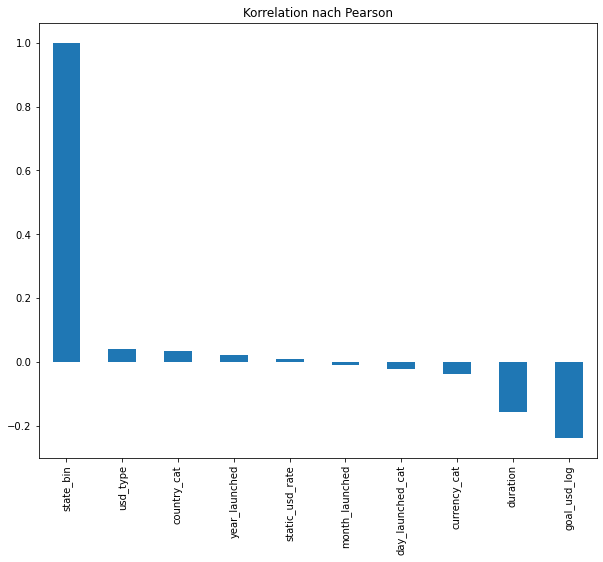

In [31]:
# correlation
basis=df_new.corr(method='pearson')['state_bin'].sort_values(axis=0, ascending=False)
basis.plot(kind='bar',figsize=(10,8),title='Korrelation nach Pearson')

## Correlations with dummyvariables

In [32]:
# get dummies
new_dummy= pd.get_dummies(df_new['maincategory_name'], prefix='new', drop_first=True)

In [33]:
new_dum = df_new.drop(['maincategory_name'], axis=1)

In [34]:
new_dum = pd.concat([new_dum,new_dummy], axis=1)

<AxesSubplot:title={'center':'Korrelation nach Pearson'}>

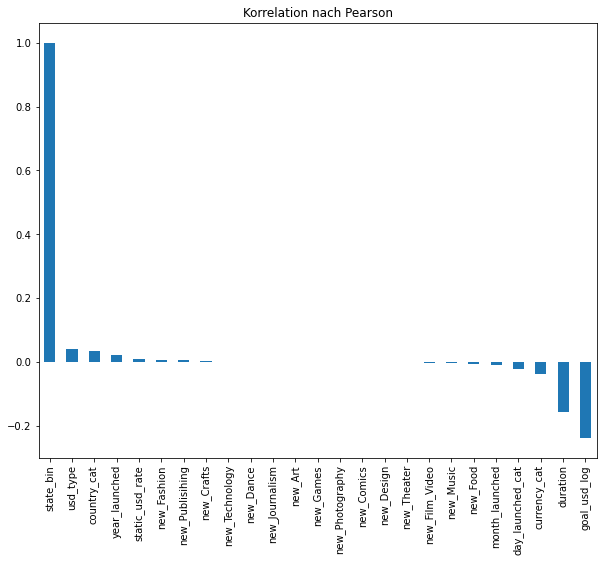

In [35]:
# correlation
corr=new_dum.corr(method='pearson')['state_bin'].sort_values(axis=0, ascending=False)
corr.plot(kind='bar',figsize=(10,8),title='Korrelation nach Pearson')

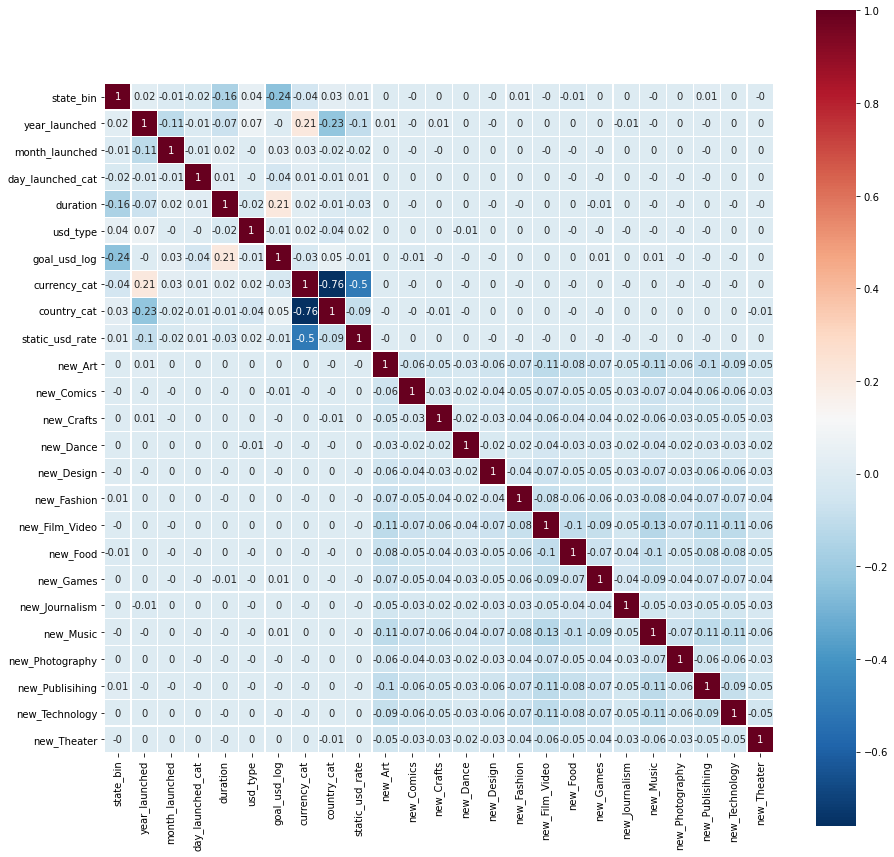

In [36]:
# heatmap - finding variables which are useful for prediction
plt.figure(figsize=(15,15))
sns.heatmap(data=new_dum.corr().round(2),annot=True,cmap='RdBu_r',linewidths=0.2,square=True);

# Modeling
<a id='model'></a>

In this section we will apply four different machine learning models for classification to the data. Our goal is to classify kickstarter projects into successesful or failed.

For each model we will evaluate the accuracy, precission and f1-score. The f1-score seems to be the most important and suitable measure, because there is no preference for false positives or false negatives (both are equally bad). 

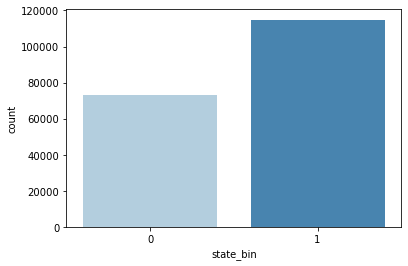

In [37]:
# countplot for our label
sns.countplot(x='state_bin',data=new_dum, palette='Blues');

# AdaBoost

In [38]:
from sklearn.ensemble import AdaBoostClassifier

In [39]:
# scaling and splitting the data into features and target label
X_unscaled = new_dum.drop(['state_bin'], axis=1)
scaler = StandardScaler()
X_new = pd.DataFrame(scaler.fit_transform(X_unscaled), columns=list(X_unscaled.columns))
y_new = new_dum['state_bin'].values

In [40]:
# Train Test Split 
from sklearn.model_selection import train_test_split

# Split the features and label data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.25, random_state = 0,stratify=y_new)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 140999 samples.
Testing set has 47000 samples.


## Modelling

In [41]:
# Step 1: Import the model want to use 
from sklearn.ensemble import AdaBoostClassifier

# Step 2: Make an instance of the Model
adaB = AdaBoostClassifier(random_state = 0, n_estimators=50, learning_rate=1)

# Step 3: Train the model on the data
adaB.fit(X_train, y_train)

# Step 4: predict the response fpr test data
y_pred = adaB.predict(X_test)

In [42]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred)))
print('Precision Score : ' + str(precision_score(y_test, y_pred)))
print('Recall Score : ' + str(recall_score(y_test, y_pred)))
print('F1 Score : ' + str(f1_score(y_test, y_pred)))

Accuracy Score : 0.6886808510638298
Precision Score : 0.7056931489224831
Recall Score : 0.8408766245078568
F1 Score : 0.7673767885532591


In [43]:
predictions = adaB.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.45      0.53     18299
           1       0.71      0.84      0.77     28701

    accuracy                           0.69     47000
   macro avg       0.67      0.65      0.65     47000
weighted avg       0.68      0.69      0.67     47000

[[ 8234 10065]
 [ 4567 24134]]


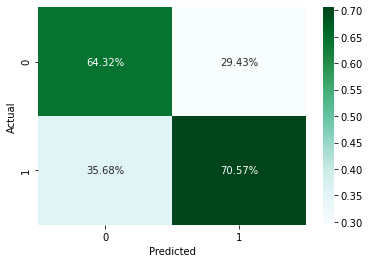

In [44]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, 
            fmt='.2%',cmap='BuGn');

## Grid Search 

In [48]:
# Import Support 
from sklearn.model_selection import GridSearchCV

# defince the hyperparameters we want to tune
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]
}

#instatioate GridSearchCV fit model and male predictio
gs_ab = GridSearchCV(AdaBoostClassifier(), param_grid = param_grid)
gs_ab.fit(X_train, y_train)
y_pred_new = gs_ab.predict(X_test)

In [49]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_new)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_new)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_new)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_new)))

Accuracy Score : 0.6917872340425532
Precision Score : 0.7067516071792187
Recall Score : 0.8465210271419115
F1 Score : 0.7703478233298457


In [50]:
predictions = adaB.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred_new))
print(confusion_matrix(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.65      0.45      0.53     18299
           1       0.71      0.85      0.77     28701

    accuracy                           0.69     47000
   macro avg       0.68      0.65      0.65     47000
weighted avg       0.69      0.69      0.68     47000

[[ 8218 10081]
 [ 4405 24296]]


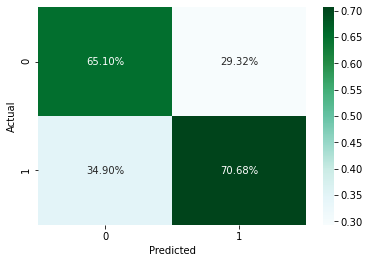

In [51]:
confusion_matrix = pd.crosstab(y_test, y_pred_new, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, 
            fmt='.2%',cmap='BuGn');

# Final model evaluation and interpretation

From beginning the **AdaBoost** had a quiet good accuracy score of around 0.68868 and a f1-score of 0.76737. After hyperparameter tuning, the model's accuracy score could be improved slighty from up to 0.691787 and the f1-score could be improved up to 0.77035. Also the precision got slightly better.

**Before:**
- Accuracy Score : 0.6886808510638298
- Precision Score : 0.7056931489224831
- Recall Score : 0.8408766245078568
- F1 Score : 0.7673767885532591

**After**
- Accuracy Score : 0.6917872340425532
- Precision Score : 0.7067516071792187
- Recall Score : 0.8465210271419115
- F1 Score : 0.7703478233298457